# FB2NEP Assignment Notebook – Personal Dataset and Analysis

This notebook supports **Part B** of the FB2NEP coursework assignment:

- It generates a **personal synthetic dataset** for you, without requiring any manual input.
- It guides you through:
  - Creating a baseline characteristics table ("Table 1").
  - Exploring distributions and considering transformations.
  - Fitting a regression model relating sugar-sweetened beverage (SSB) intake, obesity and CVD risk.
  - Obtaining output that you can copy into your Word document.

You do **not** need to understand Python code to complete this notebook. In most cases, you only need to:

1. Record the automatically generated **Population name**.
2. Run the code cells in order (top to bottom).
3. Copy selected tables and figures into your Word document.
4. Answer the questions in your own words in the Word document.

> **Important:** You may see warnings (often in yellow). These are usually harmless for this assignment. If you see a long red error message, re-run the previous cell. If the problem persists, ask for help.

## Reminder – Assignment structure

The full coursework consists of:

- **Part A (in Word only):**
  - Short knowledge questions.
  - Drawing and explaining a DAG.
  - Interpreting published results.

- **Part B (this notebook + Word):**
  - **B1:** Table 1 and commentary.
  - **B2:** Distributions and transformations.
  - **B3:** Regression model and interpretation.
  - **B4:** DAG-informed adjustment strategy.
  - Optional bonus.

This notebook is designed to support **Part B**. You will need to copy results and figures from here into your Word document and write your interpretations there.

## Variable definitions and coding

The dataset used in this assignment is **synthetic**, but its structure, distributions, and relationships are designed to resemble those commonly encountered in observational nutritional epidemiology.

You should treat the variables below **as if they originated from a real population study** and interpret them accordingly.

| Variable | Description | Coding / Units |
|--------|------------|----------------|
| `id` | Unique participant identifier | Integer |
| `age` | Age at baseline | Years (continuous) |
| `sex` | Biological sex | `"Female"`, `"Male"` |
| `ses` | Socioeconomic status | `"low"`, `"middle"`, `"high"` |
| `smoking` | Smoking status | `"never"`, `"former"`, `"current"` |
| `pa` | Physical activity level | `"low"`, `"moderate"`, `"high"` |
| `ssb` | Sugar-sweetened beverage intake | Servings per day (continuous) |
| `bmi` | Body mass index | kg/m² (continuous) |
| `obese` | Obesity indicator | `0` = BMI < 30 kg/m², `1` = BMI ≥ 30 kg/m² |
| `cvd_risk` | Composite cardiovascular disease risk score | Continuous (higher = higher risk) |

**Important notes**

- `ssb` represents habitual intake and should be interpreted as an average daily exposure.
- `cvd_risk` is a continuous score derived from multiple risk factors; it is **not** a probability or a clinical diagnosis.
- Relationships between variables reflect plausible causal structures but do not represent real individuals.


## Step 1 – Set up Python libraries

Run the cell below once. It loads the Python libraries that this notebook uses.

In [1]:
# ============================================================
# Import required Python libraries
#
# You do not need to change anything in this cell.
# Simply run it once. If you see warnings, that is usually fine.
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Make plots appear inside the notebook
%matplotlib inline

# For nicer table display (if supported)
pd.set_option("display.max_columns", 50)
pd.set_option("display.precision", 3)

print("Libraries imported successfully.")

Libraries imported successfully.


## Step 2 – Submission date (set by the module convenor)

This notebook releases the **final dataset** only within the last **two weeks** before the submission deadline.

- Before that point, the notebook runs in **preview mode** and intentionally introduces artefacts so that results are not reliable.
- From the release date onwards, the notebook generates a **final, stable dataset**.

You do not need to change anything in this section unless you are the module convenor.

In [2]:
# ============================================================
# Submission date (set by the module convenor)
#
# INSTRUCTION (convenor only):
# - Set submission_date as YYYY-MM-DD.
# - The final dataset will be available from (submission_date - 14 days).
# ============================================================

from datetime import date, datetime, timedelta

submission_date = "2026-03-01"  # <-- CONVENOR: EDIT THIS DATE (YYYY-MM-DD)

# Parse and compute release date (14 days before submission)
_submission_dt = datetime.strptime(submission_date, "%Y-%m-%d").date()
release_date = _submission_dt - timedelta(days=14)

today = date.today()
days_until_submission = (_submission_dt - today).days
days_until_release = (release_date - today).days

print(f"Submission date:  {_submission_dt.isoformat()}")
print(f"Release date:     {release_date.isoformat()} (final dataset available from this date)")
print(f"Today:            {today.isoformat()}")

if today < release_date:
    print("\nDATA STATUS: PREVIEW MODE (results intentionally perturbed; do not rely on them).")
else:
    print("\nDATA STATUS: FINAL MODE (dataset is stable and can be used for your submission).")


Submission date:  2026-03-01
Release date:     2026-02-15 (final dataset available from this date)
Today:            2026-01-30

DATA STATUS: PREVIEW MODE (results intentionally perturbed; do not rely on them).


## Step 3 – Your population name (write this down)

To ensure that each student receives a different dataset without requiring any manual input, the notebook generates a short **population name** (a random word pair).

- This population name will be shown in **Table 1** as **Population name**.
- You must **write it down** and include it in your submitted Word document.
- The population name uniquely determines your dataset.

The population name is designed to be easy to record and later verify.

In [3]:
# ============================================================
# Generate a population name and derive a dataset seed
#
# You do not need to change anything in this cell.
# IMPORTANT: write down the population name shown below.
# ============================================================

import os
import time
import secrets
import hashlib

# A small word list to generate a readable "population name"
_adjectives = [
    "amber", "brisk", "calm", "cobalt", "dapper", "frosty", "gentle", "honey",
    "ivory", "jolly", "keen", "lunar", "mellow", "navy", "olive", "plucky",
    "quiet", "rustic", "silver", "tidy", "urban", "vivid", "witty", "zesty"
]

_nouns = [
    "badger", "beacon", "cedar", "comet", "dolphin", "ember", "falcon", "garden",
    "harbour", "island", "jigsaw", "lantern", "meadow", "otter", "piano", "quartz",
    "river", "saffron", "thistle", "tulip", "valley", "walnut", "yonder", "zephyr"
]

# Build an entropy string from multiple sources (time, process, OS randomness)
_entropy = f"{time.time_ns()}|{os.getpid()}|{secrets.token_hex(16)}"
_digest = hashlib.sha256(_entropy.encode("utf-8")).digest()

adj = _adjectives[_digest[0] % len(_adjectives)]
noun = _nouns[_digest[1] % len(_nouns)]

population_name = f"{adj}-{noun}"

# Derive a stable integer seed from the population name.
# This allows the convenor to reproduce the dataset later by re-entering the population name.
_salt = "FB2NEP_assessment1_v1"
_seed_bytes = hashlib.sha256((population_name + "|" + _salt).encode("utf-8")).digest()
seed_int = int.from_bytes(_seed_bytes[:8], "big")

print("POPULATION NAME (record this):", population_name)
print("Derived seed (internal):      ", seed_int)

# Determine whether we should provide the final dataset or a perturbed preview dataset.
# - Before release_date: preview mode (intentionally perturbed; changes between runs).
# - From release_date onwards: final mode (stable for a given population name).
if today < release_date:
    dataset_mode = "PREVIEW"
    # Make the preview dataset change between runs by injecting additional time-based entropy.
    _preview_bytes = hashlib.sha256((population_name + str(time.time_ns())).encode("utf-8")).digest()
    effective_seed = int.from_bytes(_preview_bytes[:8], "big")
else:
    dataset_mode = "FINAL"
    effective_seed = seed_int

print("Dataset mode:                 ", dataset_mode)


POPULATION NAME (record this): cobalt-walnut
Derived seed (internal):       2759777107657430458
Dataset mode:                  PREVIEW


## Step 4 – Generate your dataset

The cell below will generate your dataset and store it in a pandas DataFrame called `df`. It will also save a CSV file named:

`my_fb2nep_assignment_data.csv`

**Important:**

- The dataset is determined by your **Population name**.
- In the final two weeks before the submission deadline, the notebook runs in **FINAL mode** and the dataset is stable for a given population name.
- Before that point, the notebook runs in **PREVIEW mode** and intentionally introduces artefacts, so results are not reliable and may change between runs.

You must include your **Population name** in your submitted Word document.

In [4]:
# ============================================================
# Generate the dataset for this assessment
# ============================================================

import numpy as np
import pandas as pd
from IPython.display import display

rng = np.random.default_rng(effective_seed)

# Number of participants in the synthetic cohort
n = 2000

# Study ID (1, 2, 3, ...)
study_id = np.arange(1, n + 1)

# Age: roughly 30–80 years, with a mean around 55
age = rng.normal(loc=55, scale=12, size=n)
age = np.clip(age, 30, 85)

# Sex: approximately 50 % female, 50 % male
sex = rng.choice(["Female", "Male"], size=n, p=[0.52, 0.48])

# Socioeconomic status (ses): low, middle, high
ses = rng.choice(["low", "middle", "high"], size=n, p=[0.30, 0.45, 0.25])

# Smoking status: never, former, current
smoking = rng.choice(["never", "former", "current"], size=n, p=[0.50, 0.30, 0.20])

# Physical activity (pa): low, moderate, high
pa = rng.choice(["low", "moderate", "high"], size=n, p=[0.35, 0.45, 0.20])

# Base SSB intake (servings per day): positively skewed
ssb_base = rng.gamma(shape=1.5, scale=0.7, size=n)

# SES effect: higher intake in low SES, lower in high SES
ses_effect = np.where(ses == "low", 0.6, np.where(ses == "middle", 0.2, -0.3))

# Age effect: slightly lower SSB with increasing age
age_effect = -(age - 55) * 0.01

# Sex effect: assume slightly higher SSB in males
sex_effect = np.where(sex == "Male", 0.2, 0.0)

ssb = ssb_base + ses_effect + age_effect + sex_effect
ssb = np.clip(ssb, 0, None)  # SSB cannot be negative

# BMI: mean around 27, increased by higher SSB and lower physical activity
bmi_base = rng.normal(loc=27, scale=4.5, size=n)

# Effect of SSB on BMI (small positive)
bmi_ssb_effect = ssb * 0.6

# Effect of physical activity on BMI
pa_effect = np.where(pa == "low", 1.5, np.where(pa == "moderate", 0.0, -1.0))

bmi = bmi_base + bmi_ssb_effect + pa_effect
bmi = np.clip(bmi, 16, 55)

# Obesity indicator (binary): BMI >= 30
obese = (bmi >= 30).astype(int)

# CVD risk score: linear predictor + noise, then mapped to 0–100 range
lp = (
    -5.0
    + 0.08 * (age - 55)                      # age effect
    + 0.06 * (bmi - 27)                      # BMI effect
    + 0.10 * ssb                              # SSB effect
    + np.where(sex == "Male", 0.8, 0.0)      # male sex
    + np.where(smoking == "former", 0.7, 0.0)
    + np.where(smoking == "current", 1.5, 0.0)
    + np.where(ses == "low", 0.7, 0.0)
    + np.where(ses == "high", -0.4, 0.0)
)

lp_noisy = lp + rng.normal(loc=0.0, scale=0.8, size=n)
cvd_risk = 100 / (1 + np.exp(-lp_noisy))

# ------------------------------------------------------------
# Preview mode: intentionally introduce artefacts
#
# This is used BEFORE the final dataset release date.
# Results are not reliable and may change between runs.
# ------------------------------------------------------------
if dataset_mode == "PREVIEW":
    # Flip sex labels (systematic misclassification)
    sex = np.where(sex == "Male", "Female", "Male")

    # Re-label smoking categories (artefactual distortion)
    smoking = rng.choice(["never", "former", "current"], size=n, p=[0.40, 0.35, 0.25])

    # Add additional noise to the outcome
    cvd_risk = np.clip(cvd_risk + rng.normal(loc=0.0, scale=7.0, size=n), 0, 100)

# Assemble the DataFrame
df = pd.DataFrame({
    "id": study_id,
    "age": age,
    "sex": sex,
    "ses": ses,
    "smoking": smoking,
    "pa": pa,
    "ssb": ssb,
    "bmi": bmi,
    "obese": obese,
    "cvd_risk": cvd_risk,
})

# Store identifiers (useful for your write-up and for verification)
df["population_name"] = population_name
df["dataset_mode"] = dataset_mode

print("First 5 rows of your dataset:")
display(df.head())

# Save to CSV
csv_filename = "my_fb2nep_assignment_data.csv"
df.to_csv(csv_filename, index=False)

print(f"\nDataset saved to: {csv_filename}")

if dataset_mode == "PREVIEW":
    print("\nNOTE: You are in PREVIEW mode. Results are intentionally perturbed and may change between runs.")
    print(f"The FINAL dataset will be available from: {release_date.isoformat()}")
else:
    print("\nYou are in FINAL mode. This dataset is stable for your population name and can be used for your submission.")


First 5 rows of your dataset:


,id,age,sex,ses,smoking,pa,ssb,bmi,obese,cvd_risk,population_name,dataset_mode
0,1,49.583,Male,middle,never,low,2.902,30.647,1,8.473,cobalt-walnut,PREVIEW
1,2,32.694,Male,low,current,moderate,2.929,28.754,0,6.682,cobalt-walnut,PREVIEW
2,3,61.995,Male,high,never,moderate,0.385,24.780,0,7.998,cobalt-walnut,PREVIEW
3,4,69.033,Female,low,never,moderate,2.381,24.050,0,28.155,cobalt-walnut,PREVIEW
4,5,67.318,Male,high,never,low,0.295,34.808,1,4.607,cobalt-walnut,PREVIEW



Dataset saved to: my_fb2nep_assignment_data.csv

NOTE: You are in PREVIEW mode. Results are intentionally perturbed and may change between runs.
The FINAL dataset will be available from: 2026-02-15


# Part B1 – Table 1 and commentary

In this section you will:

1. Create a baseline characteristics table ("Table 1"), comparing **obese** and **non-obese** participants.
2. Copy the table into your Word document.
3. Write a brief commentary in your Word document (approximately 150 words).

### Question B1 (to answer in Word)

**Important:** Your Table 1 includes a line called **Population name**. You must copy this into your Word document and also write the population name somewhere in your text.

**B1.** Using the table produced below:

- Comment on the main characteristics of obese vs non-obese participants (age, sex, SES, smoking, SSB intake, CVD risk).
- Highlight any substantial differences that might be epidemiologically relevant.
- Note any anomalies or possible data quality issues you observe.

You do **not** write the answer here; instead, you copy the table into Word and write your commentary there.

In [5]:
# ============================================================
# Part B1 – Create a "Table 1" by obesity status
#
# Aim:
# - produce a clean table that can be copied into Word
# - keep values short (mean ± SD; n (%))
# - show the Population name and Dataset mode clearly
# ============================================================

import pandas as pd
from IPython.display import display

def _mean_sd(x: pd.Series) -> str:
    x = pd.to_numeric(x, errors="coerce")
    return f"{x.mean():.1f} ± {x.std(ddof=1):.1f}"

def _n_pct(count: int, total: int) -> str:
    pct = 100 * count / total if total else 0.0
    return f"{count} ({pct:.1f}%)"

def make_table1_word_friendly(
    data: pd.DataFrame,
    group_var: str,
    continuous_vars: list[str],
    categorical_vars: list[str],
    group_labels: dict | None = None,
) -> pd.DataFrame:
    """Create a Word-friendly Table 1.

    Output structure:
    - Rows: variables (and levels for categorical variables)
    - Columns: each group (e.g., obese=0 vs obese=1)

    Notes:
    - Continuous variables are shown as mean ± SD.
    - Categorical variables are expanded into one row per level (n (%)).
    """

    df = data.copy()

    # Determine groups and labels
    groups = sorted(df[group_var].dropna().unique().tolist())
    if group_labels is None:
        group_labels = {g: str(g) for g in groups}

    # Prepare output rows
    rows = []

    # Continuous variables
    for var in continuous_vars:
        if var not in df.columns:
            continue
        row = {
            "Variable": var,
            "Level": "",
        }
        for g in groups:
            s = df.loc[df[group_var] == g, var]
            row[group_labels[g]] = _mean_sd(s)
        rows.append(row)

    # Categorical variables (one row per category)
    for var in categorical_vars:
        if var not in df.columns:
            continue
        for level in sorted(df[var].dropna().unique().tolist()):
            row = {
                "Variable": var,
                "Level": str(level),
            }
            for g in groups:
                sub = df.loc[df[group_var] == g, var]
                total = sub.notna().sum()
                count = (sub == level).sum()
                row[group_labels[g]] = _n_pct(int(count), int(total))
            rows.append(row)

    out = pd.DataFrame(rows)

    # Make the table a bit nicer for display
    out = out[["Variable", "Level"] + [group_labels[g] for g in groups]]

    return out

# Define friendly group labels for obesity status
group_labels = {
    0: "Not obese (BMI < 30)",
    1: "Obese (BMI ≥ 30)",
}

continuous_vars = ["age", "bmi", "ssb", "cvd_risk"]
categorical_vars = ["sex", "ses", "smoking", "pa"]

print(f"Population name: {population_name}")
print(f"Dataset mode: {dataset_mode}\n")

table1 = make_table1_word_friendly(
    df,
    group_var="obese",
    continuous_vars=continuous_vars,
    categorical_vars=categorical_vars,
    group_labels=group_labels,
)

print("Table 1 – Baseline characteristics by obesity status")
display(table1)

# Save a copy in a format that can be opened in Excel / Word
table1_filename = "table1_baseline_by_obesity.csv"
table1.to_csv(table1_filename, index=False)
print(f"\nSaved Table 1 to: {table1_filename}")

# Optional: a tab-separated version that can be copy-pasted into Word
print("\nCopy-paste version (tab-separated):\n")
print(table1.to_csv(sep="\t", index=False))


Population name: cobalt-walnut
Dataset mode: PREVIEW

Table 1 – Baseline characteristics by obesity status


,Variable,Level,Not obese (BMI < 30),Obese (BMI ≥ 30)
0,age,,54.8 ± 11.9,55.1 ± 11.8
1,bmi,,25.4 ± 3.1,33.3 ± 2.5
2,ssb,,1.3 ± 0.9,1.5 ± 1.0
3,cvd_risk,,6.2 ± 8.5,8.5 ± 11.4
4,sex,Female,641 (49.0%),354 (51.1%)
5,sex,Male,666 (51.0%),339 (48.9%)
6,ses,high,359 (27.5%),145 (20.9%)
7,ses,low,364 (27.9%),221 (31.9%)
8,ses,middle,584 (44.7%),327 (47.2%)
9,smoking,current,325 (24.9%),170 (24.5%)



Saved Table 1 to: table1_baseline_by_obesity.csv

Copy-paste version (tab-separated):

Variable	Level	Not obese (BMI < 30)	Obese (BMI ≥ 30)
age		54.8 ± 11.9	55.1 ± 11.8
bmi		25.4 ± 3.1	33.3 ± 2.5
ssb		1.3 ± 0.9	1.5 ± 1.0
cvd_risk		6.2 ± 8.5	8.5 ± 11.4
sex	Female	641 (49.0%)	354 (51.1%)
sex	Male	666 (51.0%)	339 (48.9%)
ses	high	359 (27.5%)	145 (20.9%)
ses	low	364 (27.9%)	221 (31.9%)
ses	middle	584 (44.7%)	327 (47.2%)
smoking	current	325 (24.9%)	170 (24.5%)
smoking	former	461 (35.3%)	240 (34.6%)
smoking	never	521 (39.9%)	283 (40.8%)
pa	high	309 (23.6%)	104 (15.0%)
pa	low	378 (28.9%)	284 (41.0%)
pa	moderate	620 (47.4%)	305 (44.0%)



# Part B2 – Distributions and transformations

In this section you will:

- Inspect the distributions of three key variables:
  - `ssb` (SSB intake, servings per day)
  - `bmi` (kg/m²)
  - `cvd_risk` (CVD risk score)
- Consider whether any of these variables might require transformation (for example log-transformation or categorisation) before being used in a regression model.

### Question B2 (to answer in Word)

**B2.** Based on the histograms and boxplots:

- Describe the distribution of each variable (for example symmetric, skewed, presence of outliers).
- State whether you would consider any transformation or categorisation for each variable and explain why.

Write your answer in approximately 150 words in your Word document.

> You may copy one or two plots into your Word document as illustration if you wish (this is optional but may help your explanation).

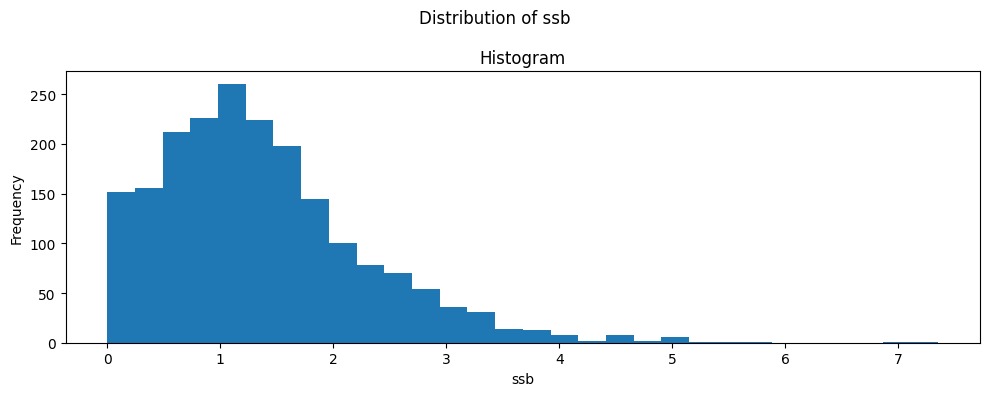

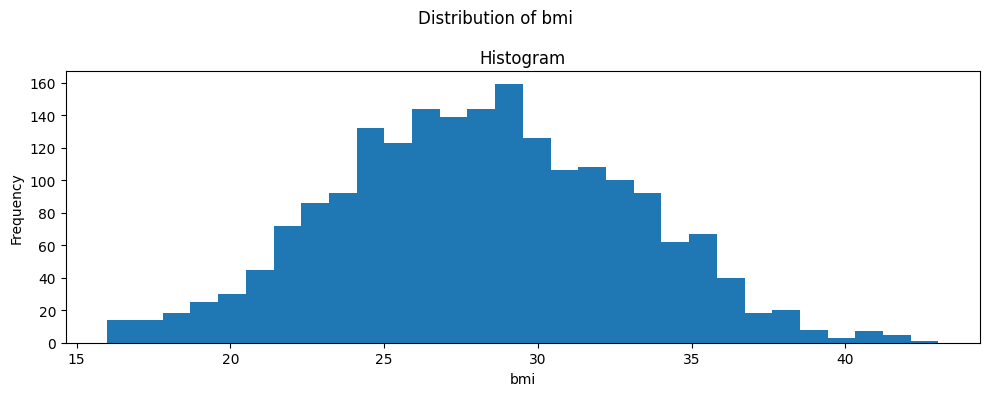

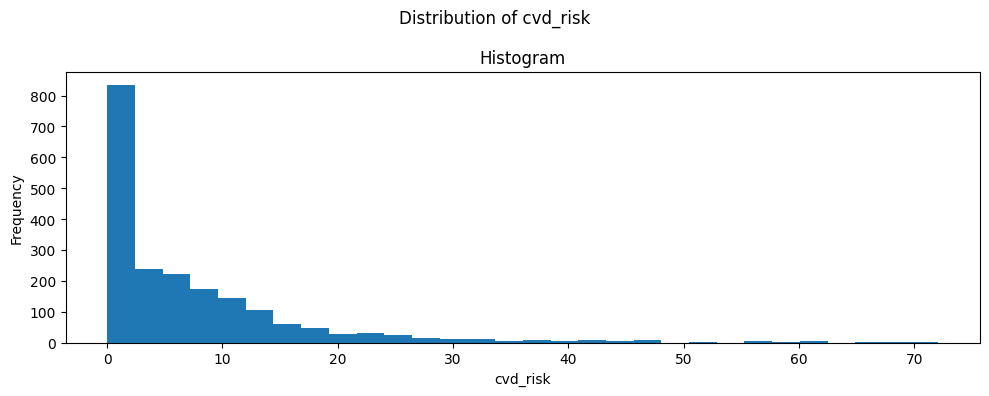

Review the plots above, then answer Question B2.


In [6]:
# ============================================================
# Plot distributions: histograms and boxplots
# ============================================================

vars_to_plot = ["ssb", "bmi", "cvd_risk"]

for var in vars_to_plot:
    if var not in df.columns:
        continue

    fig, ax = plt.subplots(figsize=(10, 4))
    fig.suptitle(f"Distribution of {var}")

    ax.hist(df[var].dropna(), bins=30)
    ax.set_xlabel(var)
    ax.set_ylabel("Frequency")
    ax.set_title("Histogram")

    plt.tight_layout()
    plt.show()


print("Review the plots above, then answer Question B2.")

# Part B3 – Regression model and interpretation

In this section you will fit a regression model that relates CVD risk to SSB intake, obesity and other covariates.

We will use a **linear regression model** with `cvd_risk` as the continuous outcome and the following predictors:

- `ssb` (continuous SSB intake)
- `obese` (0/1)
- `age` (years)
- `sex` (categorical)
- `ses` (categorical)
- `smoking` (categorical)

### Question B3

**B3.** Using the regression output:

- Interpret the estimated effect of **SSB intake** on CVD risk (direction, magnitude, and uncertainty).
- Interpret the effect of **obesity** on CVD risk.
- Comment on the effects of age and sex.
- Discuss briefly whether SES and smoking appear to confound the relationship between SSB intake and CVD risk.

Write your answer in approximately 250–350 words in your Word document.

> You should copy the regression table produced below into your document to support your interpretation.

In [7]:
# ============================================================
# Fit a linear regression model for cvd_risk
# ============================================================

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define the model formula
# C() tells statsmodels to treat the variable as categorical.
formula = "cvd_risk ~ ssb + obese + age + C(sex) + C(ses) + C(smoking)"

model = smf.ols(formula=formula, data=df).fit()

print("Linear regression model fitted. Summary:")
display(model.summary())

Linear regression model fitted. Summary:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               cvd_risk   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     64.76
Date:                Fri, 30 Jan 2026   Prob (F-statistic):           1.52e-94
Time:                        21:38:16   Log-Likelihood:                -7143.0
No. Observations:                2000   AIC:                         1.430e+04
Df Residuals:                    1991   BIC:                         1.435e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -10.5358      1.089     -9.676      0.000     -12.671      -8.400
C(sex)[T.Male]          -3.1184      0.388     -8.035      0.000      -3.880      -2.357
C(ses)[T.low]            4.3322      0.569      7.617      0.000       3.217       5.448
C(ses)[T.middle]         0.9962      0.499      1.995      0.046       0.017       1.976
C(smoking)[T.former]     0.1419      0.507      0.280      0.780      -0.853       1.137
C(smoking)[T.never]      0.2367      0.494      0.479      0.632      -0.732       1.205
ssb                      0.1317      0.230      0.573      0.567      -0.319       0.583
obese                    1.8725      0.409      4.582      0.000       1.071       2.674
age                      0.2993      0.016     18.162      0.000       0.267       0.332
==============================================================================
Omnibus:                      808.222   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4301.916
Skew:                           1.846   Prob(JB):                         0.00
Kurtosis:                       9.164   Cond. No.                         326.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
# ============================================================
# Create a concise regression table (estimates, CI, p-values)
# ============================================================

params = model.params
conf = model.conf_int()
pvals = model.pvalues

reg_table = pd.DataFrame({
    "beta": params,
    "ci_lower": conf[0],
    "ci_upper": conf[1],
    "p_value": pvals,
})

print("Concise regression table:")
display(reg_table)

print("\nNow answer Question B3, using this table and the full summary above.")

Concise regression table:


,beta,ci_lower,ci_upper,p_value
Intercept,-10.536,-12.671,-8.400,1.136e-21
C(sex)[T.Male],-3.118,-3.880,-2.357,1.588e-15
C(ses)[T.low],4.332,3.217,5.448,3.995e-14
C(ses)[T.middle],0.996,0.017,1.976,4.620e-02
C(smoking)[T.former],0.142,-0.853,1.137,7.797e-01
C(smoking)[T.never],0.237,-0.732,1.205,6.317e-01
ssb,0.132,-0.319,0.583,5.669e-01
obese,1.872,1.071,2.674,4.893e-06
age,0.299,0.267,0.332,2.502e-68



Now answer Question B3, using this table and the full summary above.


# Part B4 – DAG-informed adjustment strategy

This part links your **causal diagram (DAG)** from Part A with your regression model from Part B.

You do **not** need to run any new code here: the question is conceptual.

### Question B4 

**B4.** Using the DAG you drew in Part A for the relationship between SSB intake and CVD:

- State whether the regression model you fitted in Part B3 includes all the variables you consider necessary to control for confounding.
- Identify one variable that you think **should not** be adjusted for (for example, because it is a collider or a mediator) and explain why, based on your DAG.

Write your answer in approximately 150 words.

> You do not need to modify the code cells here. Use your DAG and regression results to reason about appropriate adjustment.

---

# Optional bonus – Exploring robustness of findings (+5 marks)

This optional bonus allows you to explore whether your main findings are
robust to alternative, **epidemiologically motivated** analytical choices.

You may choose **one** of the options below.

The emphasis is on **reasoning and interpretation**, not technical complexity.


## Bonus option A – Stratified analysis

Repeat your analysis of the association between SSB intake and CVD risk
**separately within strata** of a key variable (for example obesity status or sex).

For example, you might:
- Fit separate models for obese and non-obese participants, or
- Compare mean CVD risk across levels of SSB within strata.

### Bonus question

- Describe how the association between SSB intake and CVD risk compares across strata.
- Comment on whether stratification changes your interpretation of the main findings.
- Explain briefly why stratification can be useful in epidemiological analysis.

Maximum length: 150 words.


In [9]:
# ============================================================
# Example: Stratified analysis
#
# Stratification means analysing the association of interest
# separately within subgroups (strata) of the population.
#
# In this example, we stratify by obesity status.
# You could just as easily stratify by sex by changing ONE line
# (see comment below).
# ============================================================

# Loop over the strata we want to analyse
# Here:
#   status = 0  -> not obese
#   status = 1  -> obese
for status, label in [(0, "Not obese"), (1, "Obese")]:

    # Create a subset of the data for this stratum
    # To stratify by sex instead, you would replace this line with:
    #   df_sub = df[df["sex"] == "Female"]
    # or:
    #   df_sub = df[df["sex"] == "Male"]
    df_sub = df[df["obese"] == status]

    # Fit the regression model within this stratum
    model_strat = smf.ols(
        "cvd_risk ~ ssb + age + C(sex) + C(ses) + C(smoking)",
        data=df_sub
    ).fit()

    # Print and display the model summary
    print(f"\nStratified model: {label}")
    display(model_strat.summary())



Stratified model: Not obese


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               cvd_risk   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     37.47
Date:                Fri, 30 Jan 2026   Prob (F-statistic):           5.08e-48
Time:                        21:38:16   Log-Likelihood:                -4527.0
No. Observations:                1307   AIC:                             9070.
Df Residuals:                    1299   BIC:                             9111.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -7.8056      1.210     -6.450      0.000     -10.180      -5.432
C(sex)[T.Male]          -2.5110      0.432     -5.809      0.000      -3.359      -1.663
C(ses)[T.low]            3.7458      0.643      5.822      0.000       2.484       5.008
C(ses)[T.middle]         1.2568      0.545      2.307      0.021       0.188       2.326
C(smoking)[T.former]     0.5416      0.563      0.962      0.336      -0.563       1.646
C(smoking)[T.never]      0.6254      0.549      1.138      0.255      -0.452       1.703
ssb                     -0.1207      0.277     -0.436      0.663      -0.664       0.423
age                      0.2452      0.018     13.333      0.000       0.209       0.281
==============================================================================
Omnibus:                      571.852   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3553.625
Skew:                           1.936   Prob(JB):                         0.00
Kurtosis:                      10.090   Cond. No.                         325.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


Stratified model: Obese


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               cvd_risk   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     33.28
Date:                Fri, 30 Jan 2026   Prob (F-statistic):           6.32e-40
Time:                        21:38:16   Log-Likelihood:                -2570.5
No. Observations:                 693   AIC:                             5157.
Df Residuals:                     685   BIC:                             5193.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -13.5429      2.145     -6.314      0.000     -17.754      -9.332
C(sex)[T.Male]          -4.3177      0.762     -5.669      0.000      -5.813      -2.822
C(ses)[T.low]            5.4913      1.117      4.916      0.000       3.298       7.685
C(ses)[T.middle]         0.5848      1.027      0.570      0.569      -1.431       2.601
C(smoking)[T.former]    -0.4153      1.001     -0.415      0.678      -2.380       1.550
C(smoking)[T.never]     -0.3565      0.970     -0.368      0.713      -2.261       1.548
ssb                      0.5130      0.400      1.281      0.201      -0.273       1.299
age                      0.3927      0.032     12.194      0.000       0.329       0.456
==============================================================================
Omnibus:                      220.680   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              710.138
Skew:                           1.524   Prob(JB):                    6.24e-155
Kurtosis:                       6.911   Cond. No.                         332.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Bonus option B – Variable transformation

Apply a simple transformation to one key variable (for example SSB intake)
and repeat the analysis.

For example, you might:
- Log-transform SSB intake, or
- Categorise SSB intake into low / medium / high consumption groups.

### Bonus question

- Explain why you chose this transformation.
- Describe how the results compare with the main analysis.
- Comment on whether the transformation improves interpretability or model fit.

Maximum length: 150 words.


In [10]:
# Example: log-transform SSB (adding a small constant)
df["log_ssb"] = np.log(df["ssb"] + 0.1)

model_log = smf.ols(
    "cvd_risk ~ log_ssb + obese + age + C(sex) + C(ses) + C(smoking)",
    data=df
).fit()

display(model_log.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               cvd_risk   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     64.70
Date:                Fri, 30 Jan 2026   Prob (F-statistic):           1.79e-94
Time:                        21:38:16   Log-Likelihood:                -7143.2
No. Observations:                2000   AIC:                         1.430e+04
Df Residuals:                    1991   BIC:                         1.435e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -10.3437      1.037     -9.977      0.000     -12.377      -8.310
C(sex)[T.Male]          -3.1386      0.390     -8.047      0.000      -3.903      -2.374
C(ses)[T.low]            4.4529      0.608      7.318      0.000       3.260       5.646
C(ses)[T.middle]         1.0725      0.531      2.020      0.043       0.031       2.114
C(smoking)[T.former]     0.1463      0.508      0.288      0.773      -0.849       1.142
C(smoking)[T.never]      0.2372      0.494      0.480      0.631      -0.731       1.206
log_ssb                  0.0035      0.293      0.012      0.990      -0.571       0.578
obese                    1.8956      0.408      4.642      0.000       1.095       2.696
age                      0.2978      0.017     17.915      0.000       0.265       0.330
==============================================================================
Omnibus:                      810.053   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4326.150
Skew:                           1.849   Prob(JB):                         0.00
Kurtosis:                       9.183   Cond. No.                         316.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# End of notebook

You have now completed all the code required for **Part B** of the assignment.

Please ensure that your **document** includes:

- Table 1 from Part B1 and your commentary.
- A discussion of the distributions and any transformations (Part B2).
- Regression results and your interpretation (Part B3).
- A DAG-informed adjustment discussion (Part B4).
- Bonus analysis and interpretation (if attempted).

Remember that the emphasis of the marking is on your **epidemiological reasoning and interpretation**, not on Python code.